## Student ID : 111522071 張凱東

In [70]:
#Import data preprocessing modules
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import keras.models as k_models
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from sklearn import preprocessing
from tensorflow import keras

In [71]:
def data_preprocess(path_to_csv,is_train=0):    
    testdata = pd.read_csv(path_to_csv)
    
    testdata['Title'] = testdata['Name'].str.extract('([A-Za-z]+)\.', expand=False)

    title_mapping = {"Mr": 0,"Miss": 1,"Mrs":2,"Master":3,"Dr":3,"Rev":3,"Mlle":3,"Major":3,"Col":3,"Countess":3,"Capt":3,"Ms":3,"Sir":3,"Lady":3,"Mme":3,"Don":3,"Dona":3,"Jonkheer":3}
    testdata['Title'] = testdata['Title'].map(title_mapping)
    testdata.drop('Name',axis=1,inplace=True)

    sex_mapping = {"male":0,"female":1}
    testdata['Sex'] = testdata['Sex'].map(sex_mapping)
    testdata["Age"].fillna(testdata.groupby("Title")["Age"].transform("median"), inplace = True)

    testdata.loc[testdata["Age"] <= 10,'Age'] = 0
    testdata.loc[(testdata["Age"] > 10) & (testdata["Age"] <= 20),'Age'] = 1
    testdata.loc[(testdata["Age"] > 20) & (testdata["Age"] <= 30),'Age'] = 2
    testdata.loc[(testdata["Age"] > 30) & (testdata["Age"] <= 40),'Age'] = 3
    testdata.loc[(testdata["Age"] > 40) & (testdata["Age"] <= 50),'Age'] = 4
    testdata.loc[(testdata["Age"] > 50) & (testdata["Age"] <= 60),'Age'] = 5
    testdata.loc[(testdata["Age"] > 60) & (testdata["Age"] <= 70),'Age'] = 6
    testdata.loc[testdata["Age"] > 70,'Age'] = 7

    testdata["Embarked"] = testdata["Embarked"].fillna('S')
    e_mapping = {"S": 0,"C": 1,"Q": 2}
    testdata["Embarked"] = testdata["Embarked"].map(e_mapping)

    testdata["Fare"].fillna(testdata.groupby("Pclass")["Fare"].transform("median"), inplace = True)
    testdata.loc[testdata["Fare"] <= 17,'Fare'] = 0
    testdata.loc[(testdata["Fare"] > 17) & (testdata["Fare"] <= 30),'Fare'] = 1
    testdata.loc[(testdata["Fare"] > 30) & (testdata["Fare"] <= 100),'Fare'] = 2
    testdata.loc[testdata["Fare"] > 100 ,'Fare'] = 3

    testdata["Cabin"] = testdata["Cabin"].str[:1]
    c_mapping = {"A": 0,"B": 0.4,"C": 0.8,"D": 1.2,"E": 1.6,"F": 2,"G": 2.4,"T": 2.8}
    testdata["Cabin"] = testdata["Cabin"].map(c_mapping)
    testdata["Cabin"].fillna(testdata.groupby("Pclass")["Cabin"].transform("median"), inplace = True)
    testdata["FamilySize"] = testdata["SibSp"] + testdata["Parch"] + 1
    f_mapping = {1:0,2:0.4,3:0.8,4:1.2,5:1.6,6:2,7:2.4,8:2.8,9:3.2,10:3.6,11:4}
    testdata["FamilySize"] = testdata["FamilySize"].map(f_mapping)

    testdata.drop(['Ticket','SibSp','Parch','PassengerId'],axis=1,inplace=True)

    print(testdata.info())

    if is_train == 1:
        y = testdata[['Survived']]
        testdata.drop(['Survived'],axis = 1,inplace = True)

        minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
        scaledFeatures=minmax_scale.fit_transform(testdata)
        print(scaledFeatures)
        
        return scaledFeatures,y
    
    if is_train == 0:

        minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
        scaledFeatures=minmax_scale.fit_transform(testdata)
        print(scaledFeatures)
        
        return scaledFeatures

In [72]:
# Machine learning module
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def build_DNN_model():
    model = k_models.Sequential()
    model.add(Dense(input_dim=8,units=60,activation='LeakyReLU'))
    model.add(Dense(units= 30,activation='LeakyReLU'))
    model.add(Dense(units= 1,activation='sigmoid'))
    model.summary()
    return model

def build_SVM_model():
    model = SVC(gamma='scale')
    return model

def build_RandomForest_model():
    model = RandomForestClassifier(n_estimators=100)
    return model

In [73]:
def fit_model(model,data_x,data_y):
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['acc'])
    train_history = model.fit(x=data_x,y=data_y,validation_split=0.2,batch_size=200,epochs=100)

    return train_history

In [74]:
def model_loss(model,data_x,data_y):
    #Evaluate training result
    score = model.evaluate(x=data_x,y=data_y)
    print('\nTrain Loss:',score[0])
    print ('\nTrain Acc:', score[1])

In [75]:
def show_train_history(train_history,train,validation,label):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(label)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

In [76]:
def make_csv(probability,path_to_file,file_name):
    submission = pd.DataFrame({
    "PassengerId": pd.read_csv(path_to_file)["PassengerId"],
    "Survived": probability
    })

    submission.to_csv(file_name +'.csv', index=False)
    display(submission.head(20))

### Training

In [77]:
#RF training
path_to_file = 'input/titanic.csv'
train_x,train_y = data_preprocess(path_to_file,is_train=1)

RandomForest = build_RandomForest_model()
RandomForest.fit(train_x,train_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       891 non-null    float64
 6   Embarked    891 non-null    int64  
 7   Title       891 non-null    int64  
 8   FamilySize  891 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 62.8 KB
None
[[1.         0.         0.28571429 ... 0.         0.         0.1       ]
 [0.         1.         0.42857143 ... 0.5        0.66666667 0.1       ]
 [1.         1.         0.28571429 ... 0.         0.33333333 0.        ]
 ...
 [1.         1.         0.28571429 ... 0.         0.33333333 0.3       ]
 [0.         0.         0.28571429 ... 0.5        0.         0.        ]
 [1.         0.    

C:\Users\user\AppData\Local\Temp\ipykernel_24544\2757769042.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest.fit(train_x,train_y)


RandomForestClassifier()

In [78]:
#SVM training
path_to_file = 'input/titanic.csv'
train_x,train_y = data_preprocess(path_to_file,is_train=1)

SVM = build_SVM_model()
SVM.fit(train_x,train_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       891 non-null    float64
 6   Embarked    891 non-null    int64  
 7   Title       891 non-null    int64  
 8   FamilySize  891 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 62.8 KB
None
[[1.         0.         0.28571429 ... 0.         0.         0.1       ]
 [0.         1.         0.42857143 ... 0.5        0.66666667 0.1       ]
 [1.         1.         0.28571429 ... 0.         0.33333333 0.        ]
 ...
 [1.         1.         0.28571429 ... 0.         0.33333333 0.3       ]
 [0.         0.         0.28571429 ... 0.5        0.         0.        ]
 [1.         0.    

c:\Users\user\anaconda3\envs\Py39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       891 non-null    float64
 6   Embarked    891 non-null    int64  
 7   Title       891 non-null    int64  
 8   FamilySize  891 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 62.8 KB
None
[[1.         0.         0.28571429 ... 0.         0.         0.1       ]
 [0.         1.         0.42857143 ... 0.5        0.66666667 0.1       ]
 [1.         1.         0.28571429 ... 0.         0.33333333 0.        ]
 ...
 [1.         1.         0.28571429 ... 0.         0.33333333 0.3       ]
 [0.         0.         0.28571429 ... 0.5        0.         0.        ]
 [1.         0.    

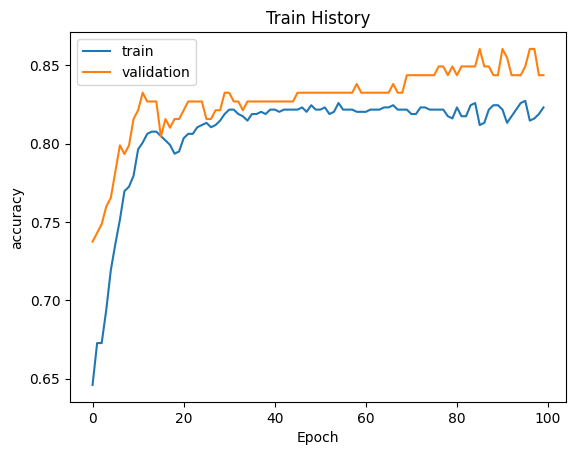

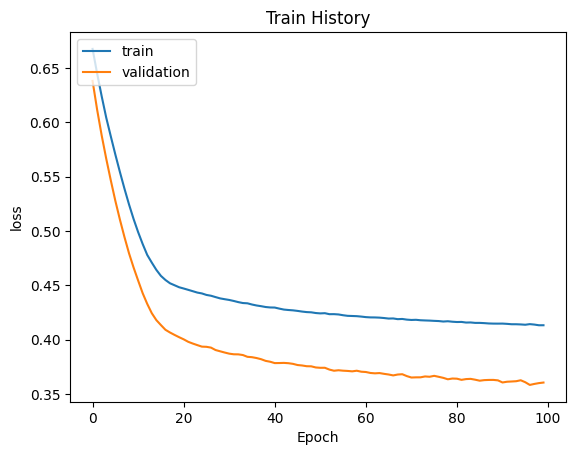

28/28 [==============================] - 0s 566us/step - loss: 0.4022 - acc: 0.8283

Train Loss: 0.4022148549556732

Train Acc: 0.8282828330993652


In [79]:
#DNN training
path_to_file = 'input/titanic.csv'
train_x,train_y = data_preprocess(path_to_file,is_train=1)

#train model
DNN = build_DNN_model()
train_history = fit_model(DNN,data_x=train_x,data_y=train_y)

#Show Training Process
show_train_history(train_history,'acc','val_acc','accuracy')
show_train_history(train_history,'loss','val_loss','loss')

#get model score
model_loss(DNN,train_x,train_y)

### save model 

In [80]:
#Save the model
DNN.save('mymodel.h5')

### Predict

In [83]:
#predict
path_to_file = "input/test.csv"
data_x = data_preprocess(path_to_file)

#make csv
pro = RandomForest.predict(data_x).flatten().round(0).astype(int)
print(pro)
make_csv(pro,path_to_file,file_name="RandomForest")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   Fare        418 non-null    float64
 4   Cabin       418 non-null    float64
 5   Embarked    418 non-null    int64  
 6   Title       418 non-null    int64  
 7   FamilySize  418 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 26.2 KB
None
[[1.         0.         0.42857143 ... 1.         0.         0.        ]
 [1.         1.         0.57142857 ... 0.         0.66666667 0.1       ]
 [0.5        0.         0.85714286 ... 1.         0.         0.        ]
 ...
 [1.         0.         0.42857143 ... 0.         0.         0.        ]
 [1.         0.         0.28571429 ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.5        1.        

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
